In [1]:
from datetime import datetime, timedelta
from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

# warnings.filterwarnings('ignore', category=ValueWarning)
# warnings.filterwarnings('ignore', category=HessianInversionWarning)
# warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

ModuleNotFoundError: No module named 'tqdm'

# ARMA(p,q) model

In [2]:
def run_simulation(returns, prices, amt, order, threshold, verbose=False):

    if type(order) == float:
        threshold = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        if curr_holding:
            
            curr_holding = False
            sell_price = prices.loc[date]
            realized_return = (sell_price - buy_price) / buy_price
            amt *= (1+realized_return)
            events_list.append(('s', date, realized_return))
            
            if verbose:
                print('sell $%s'%sell_price)
                #print('Predicted Return: %s'%round(pred,4))
                print('final return %s'%(round(realized_return, 4)))
                print('---------------------------------------')
            continue
        
        curr_data = returns[:date]
        
        if type(order) == tuple:

            try:
                model = ARIMA(curr_data, order=order).fit()  
                pred = model.forecast()[0][0]
            except Exception as e:
                pred = threshold - 1
                print('bruh moment')
                print(e)

        if (type(order) == float and np.random.random() < order) \
        or (type(order) == tuple and pred > threshold):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            
            if verbose:
                print('buy $%s'%buy_price)
                
    if verbose:
        print('total $%s'%round(amt,2))
    
    return amt

# Data

In [4]:
df = pd.read_csv('../../bitcoin-printer/data/BTCUSDT-minute.csv')

In [5]:
df

timestamp      open      high       low     close  \
0        2017-08-17 04:00:00   4261.48   4261.48   4261.48   4261.48   
1        2017-08-17 04:01:00   4261.48   4261.48   4261.48   4261.48   
2        2017-08-17 04:02:00   4280.56   4280.56   4280.56   4280.56   
3        2017-08-17 04:03:00   4261.48   4261.48   4261.48   4261.48   
4        2017-08-17 04:04:00   4261.48   4261.48   4261.48   4261.48   
...                      ...       ...       ...       ...       ...   
1988733  2021-06-03 20:24:00  38665.26  38689.56  38655.91  38682.52   
1988734  2021-06-03 20:25:00  38682.52  38682.53  38643.07  38649.70   
1988735  2021-06-03 20:26:00  38649.69  38682.52  38649.69  38682.52   
1988736  2021-06-03 20:27:00  38682.52  38682.69  38640.40  38649.38   
1988737  2021-06-03 20:28:00  38649.38  38718.00  38648.01  38700.51   

            volume  
0         1.775183  
1         0.000000  
2         0.261074  
3         0.012008  
4         0.140796  
...            ...  
1988733  14.795718  
1988734  16.778473  
1988735  15.709853  
1988736  23.010205  
1988737  48.112405  

[1988738 rows x 6 columns]

In [6]:
#df.to_csv('../../bitcoin-printer/data/BTCUSDT-minute.csv', index=False)

In [7]:
df1 = df.drop(['open', 'high', 'low'], axis=1).reset_index(drop=True)

In [8]:
df1['returns'] = df1['close'].pct_change()
df1.dropna(axis=0, inplace=True)

In [9]:
df2 = df1.iloc[::60].reset_index(drop=True)

In [10]:
df2

timestamp     close     volume   returns
0      2017-08-17 04:01:00   4261.48   0.000000  0.000000
1      2017-08-17 05:01:00   4308.83   0.136105  0.000000
2      2017-08-17 06:01:00   4315.32   0.000000  0.000000
3      2017-08-17 07:01:00   4324.35   0.000000  0.000000
4      2017-08-17 08:01:00   4349.99   0.000000  0.000000
...                    ...       ...        ...       ...
33141  2021-06-03 15:52:00  38441.00  40.690486  0.000512
33142  2021-06-03 16:52:00  38838.31  19.845042  0.001125
33143  2021-06-03 17:52:00  38866.60  64.289738  0.000532
33144  2021-06-03 18:52:00  38534.73  32.359538 -0.001229
33145  2021-06-03 19:52:00  38571.56  14.385890 -0.000538

[33146 rows x 4 columns]

## Plotting

Text(0, 0.5, 'close')

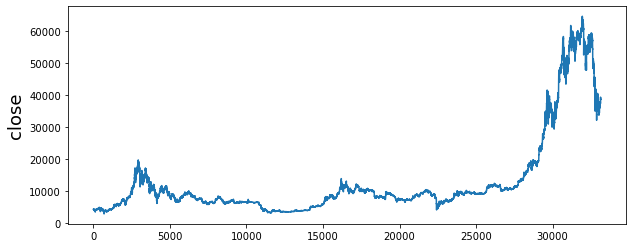

In [42]:
plt.figure(figsize=(10,4))
plt.plot(df2['close'])
plt.ylabel('close', fontsize=18)

Text(0, 0.5, 'returns')

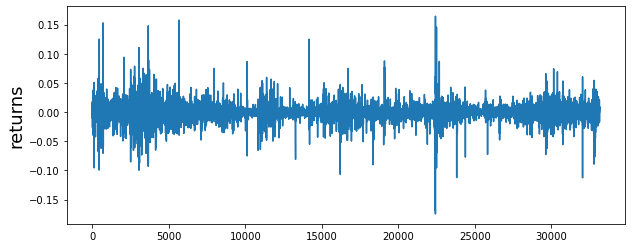

In [43]:
plt.figure(figsize=(10,4))
plt.plot(df2['returns'])
plt.ylabel('returns', fontsize=18)

## Autocorrelation

<Figure size 720x720 with 0 Axes>

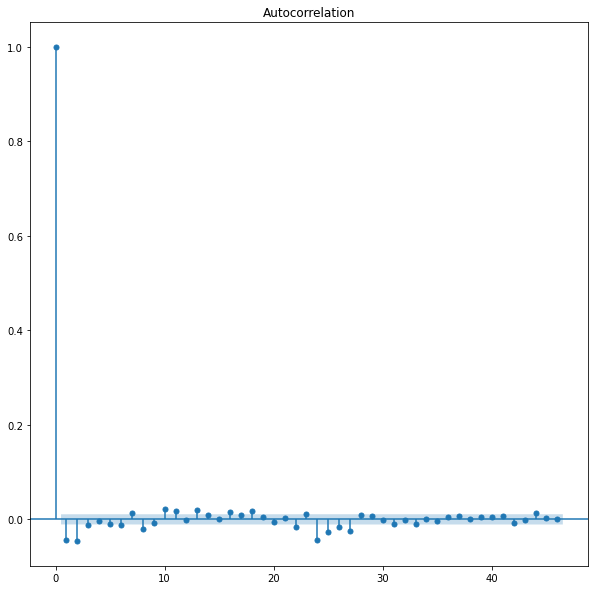

In [44]:
plt.figure(figsize=(10,10))
fig = plot_acf(df2['returns'])
fig.set_size_inches(10,10)

<Figure size 720x720 with 0 Axes>

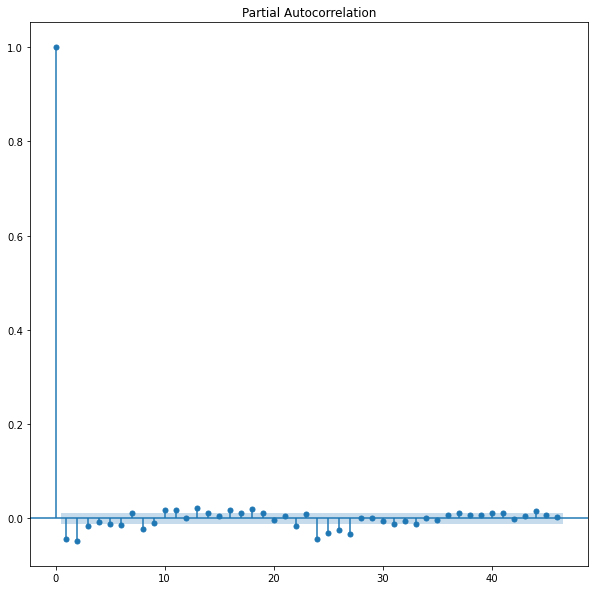

In [45]:
plt.figure(figsize=(10,10))
fig = plot_pacf(df2['returns'])
fig.set_size_inches(10,10)

# Random buying

In [11]:
run_simulation(df2['returns'][30000:], df2['close'][30000:], 100, 0.5, None, verbose=False)

100%|██████████| 3132/3132 [00:00<00:00, 29725.84it/s]


107.6191950344062

In [13]:
final_amts = [run_simulation(df2['returns'][30000:], df2['close'][30000:], 100, 0.5, None, verbose=False) for _ in range(500)]

100%|██████████| 3132/3132 [00:00<00:00, 30782.80it/s]


Text(0.5, 1.0, 'Avg: $109.81\nSD: $28.46')

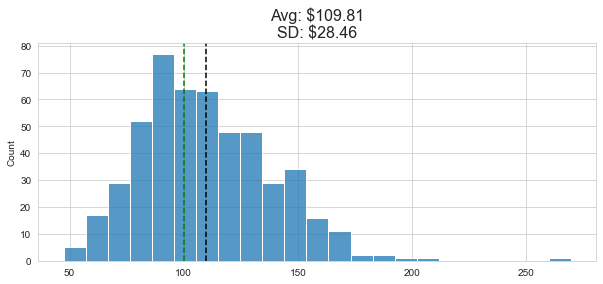

In [14]:
plt.figure(figsize=(10,4))
sns.set_style("whitegrid")
sns.histplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=16)

# AR(1)

In [86]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (1,0,0), 0, verbose=False)

100%|██████████| 3132/3132 [01:18<00:00, 40.15it/s]


87.10376024652243

In [89]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (1,0,0), 0.001, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
100%|██████████| 3132/3132 [01:58<00:00, 26.44it/s]


98.68975265973636

In [94]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (1,0,0), 0.002, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
100%|██████████| 3132/3132 [02:00<00:00, 26.08it/s]


100

In [91]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (1,0,0), 0.003, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
100%|██████████| 3132/3132 [02:00<00:00, 25.93it/s]


100

In [92]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (1,0,0), 0.004, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
100%|██████████| 3132/3132 [02:03<00:00, 25.43it/s]


100

# AR(5)

In [95]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (5,0,0), 0.001, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1572: RuntimeWarning: inva

99.41320682226169

## AR(10)

In [97]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (5,0,0), 0.002, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1572: RuntimeWarning: invalid value encountered in sqrt
  fcasterr = np.sqrt(sigma2 * np.cumsum(ma_rep ** 2))
100%|██████████| 3132/3132 [09:16<00:00,  5.63it/s]


99.4801583043666

# ARMA(5,5)

In [108]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (1,0,1), 0, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarni

division by zero
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
division by zero


  0%|          | 7/3132 [00:00<02:00, 25.95it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning

123.00628352143094

In [111]:
run_simulation(df2['returns'][30000:].reset_index(drop=True), 
               df2['close'][30000:].reset_index(drop=True), 100, (5,0,5), 0.002, verbose=False)

  0%|          | 0/3132 [00:00<?, ?it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarni

division by zero
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
division by zero


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
  0%|          | 4/3132 [00:00<12:54,  4.04it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.ari

SVD did not converge


  0%|          | 9/3132 [00:19<2:41:15,  3.10s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
  0%|          | 10/3132 [00:21<2:31:11,  2.91s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packa

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
  1%|          | 17/3132 [00:36<1:38:32,  1.90s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
  1%|          | 19/3132 [00:37<1:13:43,  1.42s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
           

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
  1%|          | 20/3132 [00:40<1:33:53,  1.81s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
  2%|▏         | 66/3132 [03:25<2:44:51,  3.23s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
  2%|▏         | 74/3132 [03:52<2:51:21,  3.36s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
  4%|▎         | 115/3132 [07:26<3:43:46,  4.45s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
  6%|▌         | 187/3132 [12:51<2:46:37,  3.39s/it]

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
  6%|▌         | 192/3132 [13:11<2:46:27,  3.40s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
          

SVD did not converge


  6%|▌         | 193/3132 [13:16<3:07:10,  3.82s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
  6%|▌         | 194/3132 [13:24<4:01:32,  4.93s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-pa

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
  7%|▋         | 212/3132 [15:01<3:23:19,  4.18s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWar

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
  8%|▊         | 241/3132 [17:26<2:22:39,  2.96s/it]

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
  8%|▊         | 242/3132 [17:30<2:34:13,  3.20s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWar

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
  9%|▉         | 276/3132 [20:31<3:29:21,  4.40s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWar

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 10%|█         | 328/3132 [25:58<3:14:15,  4.16s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWar

SVD did not converge


 11%|█         | 340/3132 [27:08<4:48:03,  6.19s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 11%|█         | 341/3132 [27:13<4:30:55,  5.82s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-pa

SVD did not converge


 11%|█         | 343/3132 [27:22<4:09:57,  5.38s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarni

SVD did not converge


 12%|█▏        | 362/3132 [28:39<4:18:20,  5.60s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 12%|█▏        | 363/3132 [28:43<3:42:49,  4.83s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-pa

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
 14%|█▍        | 442/3132 [36:53<4:58:48,  6.66s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
 14%|█▍        | 453/3132 [37:48<2:31:01,  3.38s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
          

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
 14%|█▍        | 454/3132 [37:55<3:25:48,  4.61s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
 15%|█▌        | 473/3132 [39:56<3:52:19,  5.24s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa

SVD did not converge


 16%|█▌        | 496/3132 [42:00<2:51:47,  3.91s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarni

SVD did not converge


 18%|█▊        | 579/3132 [1:50:55<3:43:39,  5.26s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWar

SVD did not converge


 19%|█▉        | 592/3132 [1:52:03<3:00:23,  4.26s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 19%|█▉        | 593/3132 [1:52:07<2:53:54,  4.11s/it]/Users/Tate/opt/anaconda3/lib/python3.8/sit

SVD did not converge


 21%|██▏       | 672/3132 [2:00:46<3:13:44,  4.73s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWar

SVD did not converge


 22%|██▏       | 698/3132 [2:03:22<2:28:23,  3.66s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWar

SVD did not converge


 23%|██▎       | 717/3132 [2:05:13<3:01:14,  4.50s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 23%|██▎       | 718/3132 [2:05:17<2:48:35,  4.19s/it]/Users/Tate/opt/anaconda3/lib/python3.8/sit

SVD did not converge


 23%|██▎       | 724/3132 [2:05:51<2:52:08,  4.29s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 23%|██▎       | 725/3132 [2:05:55<2:49:18,  4.22s/it]/Users/Tate/opt/anaconda3/lib/python3.8/sit

SVD did not converge


/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 25%|██▌       | 789/3132 [2:14:14<3:56:47,  6.06s/it]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureW

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


 68%|██████▊   | 2118/3132 [5:27:28<11:19,  1.49it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 68%|██████▊   | 2119/3132 [5:27:29<12:03,  1.40it/s]/Users/Tate/opt/anaconda3/lib/python3.8/site-

101.8932982709948